# Introduction
<p>This notebook is a tutorial on the very powerful and elegent ensemble learning method known as Gradient Boosted Trees. This tutorial is organized as follows:<br>
<ul>
    <li>Theory, Derivation and Motivation</li>
    <li>Simple illustration of fitting and model selection on simulated data</li>
    <li>Comparison between GBT and other popular non-linear techniques on simulated data</li>
    <li>References</li>
</ul><br>
There are many resources and tutorials available for learning about Gradient Boosted Trees. In an effort to attempt an original contribution, my goal here is to provide a comprehensive overview of the relevant theory as well as serve as a practical guide to implementing in Python. I have found that most tutorials cover one or the other. Additionally, I find that that vizualing a classifier's behavior is a great way to fully understanding what the theory attempts to express. Many of the vizualiztions below serve to illustrate the underlying mechanics of the method.
</p>

# Theory, Algorithm and Derivation
<p>The following sections go into increasing technical depth about GBTs. The first part introduces the basic functional form of a GBT. This should be the minimum that one learns to have at least a baseline understanding of the method. Next is presented the algorithm. Understanding the training algorithm leads to a nice intuitve understanding as to why the method works so well. It also helps to solidify the roles of the different hyperparameters. The last section derives the GBT algorithm. Knowing this is a nice way to geek out. 


</p>

### Basic Functional Form
<p>A Gradient Boosted Tree classifier can be thought of as a linear classifier over features that are learned specifically on your training data. The GBT classifier has the following functional form:

<center>$P(Y|X) = [1 + e^{-F^m(X)}]^{-1}$</center><br>where,<br>

<center>$F^m(X) = \sum\limits_{j=1}^{m}\gamma_j * T(X;\Theta_j)$</center><br><br>

Notice that this functional form is nearly identical to standard Logistic Regression. They are similar in using the inverse logit to convert a linear function of $X$ to a probability. They are different in how the linear function is built. Additionally, each "feature" $T(X;\Theta_j)$ in this linear function is a Decision Tree learned over some subpace of the original data. The power of GBTs is in how it learns and weights these component trees in such a way that it can approximate any non-linear function between $X$ and $Y$. 
</p>

### Generic Algorithm
<p>
<ul>
<li>Initialize the model with a constant value: $F^0(X) = \underset{\gamma} {\mathrm{argmin}} \: \mathbb{L}(\gamma,\, Y)$</li>

<li>For m=1 to M:</li>
<ul>

<li>Compute the gradient (pseudo residual) $r_{im}=-\nabla_f \, \mathbb{L}(F^{m-1}(x_i))$ for each data point. </li>
<li>Use least squares to fit a tree $T(X;\Theta_m)$ to the residuals $r_{im}$. Each tree can be defined by $J$ regions, each denoted $R_{jm}$.</li>

<li>Using each $R_{jm}$, identify the optimal step size using 
$\gamma_{jm} =\underset{\gamma} {\mathrm{argmin}} \: \sum\limits_{x_i \in R_{jm}} \mathbb{L}(F^{m-1}(x_i) + \gamma, y_i)$</li>

<li>Update the base function: $F^m(X) = F^{m-1}(X) + +\nu \, \sum\limits_{j=1}^J\gamma_{jm} \, I(X \in R_{jm})$</li>
</ul>

</ul>



</p>



### Derivation of Learning Algorithm
<p>Learning a GBT classifier fits within the ERM framework. We showed above that the basic functional form of a GBT is $F^m(X)=\sum\limits_{j=1}^m f_j(X)$. To find the optimal $F^m(X)$, we define the following optimization problem:<br><br>

<center>$F^{*}(X)= \underset{\mathbb{F}} {\mathrm{argmin}} \: \mathbb{L}(F^m(X),\, Y)$</center><br>



For classification, we will use Log-Loss as our objective function:<br><br>
<center>$\mathbb{L}(F^m(X),\, Y) =-\sum\limits_{i=1}^n y_i\,ln\,(p_i)+(1-y_i)\,ln\,(1-p_i)$</center><br><br>
where $p(x_i)$ is defined using the inverse logit function. We can make this problem more palatable by solving it in a greedy, stagewise manner. If we have solved up to $F^{m-1}(X)$, we update the problem by finding the next best function $f(X)$ to add to $F^{m-1}(X)$. This leads to the following:<br><br>


<center>$F^{m}(X)= F^{m-1}(X) \:+\: \underset{f} {\mathrm{argmin}} \: \mathbb{L}(F^{m-1}(X) \,+\, f(X),\, Y)$</center><br><br>

In lieu of solving for the optimal $f(X)$ directly, we employ a steepest descent line search to move closer to the optimal loss. This can be expressed as:<br><br>

<center>$F^m(X) = F^{m-1}(X) - \gamma_m * \nabla_f \, \mathbb{L}(F^{m-1}(X) \,+\, f(X))$</center><br><br>

Where the gradient $\nabla_f \mathbb{L}$ is with respect to the function $f(X)$. If we know the gradient exactly, we can compute the best step direction by solving:<br><br>

<center>$\gamma^* = \underset{\gamma} {\mathrm{argmin}} \: \mathbb{L}(F^{m-1}(X) \,-\, \gamma \nabla_f \mathbb{L})$</center><br><br>

In order to better generalize, we want to approximate the gradient with a function that is highly correlated to it, but is defined over $X$ values not in the training data. Any family of functions is suitable, but a popular choice is decision tree. So before solving the line search, we first find a tree $T(X;\Theta_m)$ that best approximates the negative gradient at each boosting step. This can be expressed as:<br><br>

<center>$T(X;\Theta_m) = \underset{\Theta}{\mathrm{argmin}} (-\nabla_f \, \mathbb{L} - T(X;\Theta))^2$</center><br><br>

So after this step is done, we do the line search using the fitted tree and not the actual gradient. Our final optimzation step is then:<br><br>

<center>$\gamma_m = \underset{\gamma} {\mathrm{argmin}} \: \mathbb{L}(F^{m-1}(X) \,-\, \gamma T(X;\Theta_m))$</center><br><br>

With this we update our base function:

<center>$F^m(X) = F^{m-1}(X) + \gamma_m \, T(X;\Theta_m)$</center><br><br>

So to recap the above, at each step we do the following:<br>
<ul>
<li>Compute the gradient $\nabla_f \, \mathbb{L}(F^{m-1}(X) \,+\, f(X))$ over the data </li>
<li>Use least squares to fit a tree $T(X;\Theta_m)$ to the gradient.</li>
<li>Using $T(X;\Theta_m)$, identify the optimal step size $\gamma_m$</li>
<li>Update the base function.</li>
</ul>
</p>

### Fitting Residuals
<p>In the line search steps above, we used a decision tree to make a best least squares approximation to the gradient of the loss function. This is well motivated mathematically, but there is also a very intuitive interpretation to this. The gradient of $\mathbb{L}$ with respect to $f(X)$ is essentially the residual between $Y$ and $F^{m-1}(X)$. So for ordinary least squares, the gradient is $\nabla_f \mathbb{L} = Y-F^{m-1}(X)$, and for classification, we have $\nabla_f \mathbb{L} = Y-p(X)$.<br><br>
When we think about the tree fitting step above, what we are really doing is fitting a tree to the residuals of the $(m-1)th$ step. Each boosting step then emphasizes the data points where predictions are the most incorrect.
</p>

### Regularization

<p>As with any prediction model, we need to take care to avoid over-fitting. This is done by adding a dampening constant to the estimate of $F^m(X)$. Specifically, we introducte $\nu$, such that:<br><br>
<center>$F^m(X) = F^{m-1}(X) + \nu \, \gamma_m \, T(X;\Theta_m)$</center><br><br>
The value of $\nu$ is usually find with a grid-search and cross-validation procedure. 

</p>


## A Simulation Study

<p>
A good way to understand gradient boosting is to work with a small dataset in which we know the true data generating function $F^*(X)$. For this example we have $X$ uniformly distributed in the unit square, and $Y$ is distributed as such:<br><br>

<center>$Y = I((X_1 - 0.5)^2 + (X_2 - 0.5)^2 + \epsilon < \delta)$</center><br><br>
Here $I(*)$ is the indicator function that returns $1$ if the expression is true, and $\epsilon \sim N(0,\sigma^2)$. The additive gaussian noise determines how cleanly any decision function can separate the classes.<br><br>

For this simulation, we will first generate training and testing sets, and then do several experiments to illustrate the boosting procedure.
<p>

Text(0.5, 1.0, 'Simulated 2-Class Data')

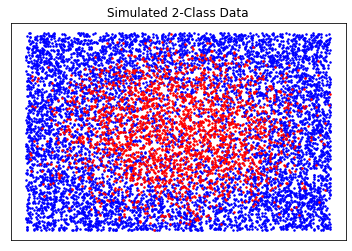

In [1]:
#Generate random data with classes separated by a circle with some gaussian noise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

n = 10000
circle = [(0.5, 0.5), 0.25]
sig = 0.1

X1 = np.random.random(n)
X2 = np.random.random(n)
Y = 1*(((X1 - circle[0][0])**2 + (X2 - circle[0][1])**2 + np.random.randn(n)*sig) < circle[1]**2)
X = pd.DataFrame({'X1':X1, 'X2':X2})

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(X1[(Y==0)], X2[(Y==0)], 'b.', markersize=3)
plt.plot(X1[(Y==1)], X2[(Y==1)], 'r.', markersize=3)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Simulated 2-Class Data')

<p>
Now let's compare training and test error as a function of the # of estimators. Note that since this data has only 2 features, we only need a max_depth of 2 for the decision trees to express any interactions that may exist in the data. 
<p>

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score

split_ind = int(0.7 * len(Y))

X_train = X[:split_ind]
Y_train = Y[:split_ind]
X_test = X[split_ind:]
Y_test = Y[split_ind:]

n_est_lim = 1000
gbc = GradientBoostingClassifier(n_estimators = n_est_lim, max_depth = 2)
gbc.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

<p>Now lets plot using the staged_predict_proba method for GradientBoostingClassifier. This method returns a generator that when called can give us the predictions at each stage of the model building process. This will let us see how training and test error (Log-Loss) evolve as we grow the model.</p>

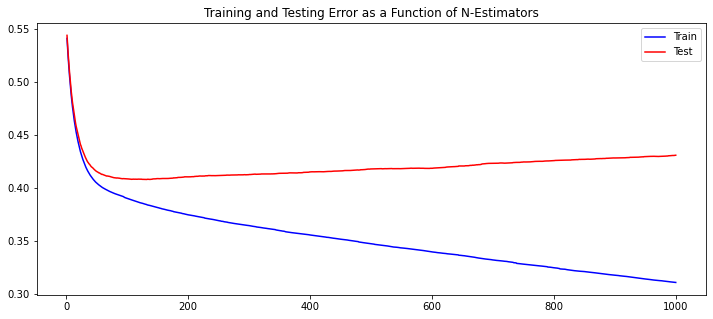

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5


def LogLossP(Pt, Yt):
    return -1*((Yt==1)*np.log(Pt)+(Yt==0)*np.log(1-Pt)).mean()

p_train = gbc.staged_predict_proba(X_train)
p_test = gbc.staged_predict_proba(X_test)

ll_train = []
ll_test = []

for p in p_train:
    ll_train.append(LogLossP(p[:, 1], Y_train))
    
for p in p_test:
    ll_test.append(LogLossP(p[:, 1], Y_test))
    

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, n_est_lim + 1), ll_train, 'b-', label='Train')
plt.plot(np.arange(1, n_est_lim + 1), ll_test, 'r-', label='Test')
plt.title('Training and Testing Error as a Function of N-Estimators')
plt.legend()

<p>We can see above the typical pattern as we make a classifier more complex. In this case, the power of the classifier improves dramatically in the first few dozen iterations. After that, we see a continual improvement in Training error, but of course at the cost of good Test error. Notice though the cost of overfitting is fairly mild here. So having too many iterations is better than having too few. <br><br>

Next let's actually visualize what the classifier is doing. Remember that our function here is an additive function of weighted trees.<br><br>

<center>$F^m(X) = \sum\limits_{j=1}^{m}\gamma_j * T(X;\Theta_j)$</center><br><br>

The first thing we can do to better understand this function is plot the decision boundaries of the first $k$ terms. The GradientBoostedClassifier object has an attribute estimators_ that is a list with each element being a component tree. We can thus plot the decision surface of each tree. Note too that the base function is a regression tree, since we are predicting residuals at each step and not the actual label. 

</p>

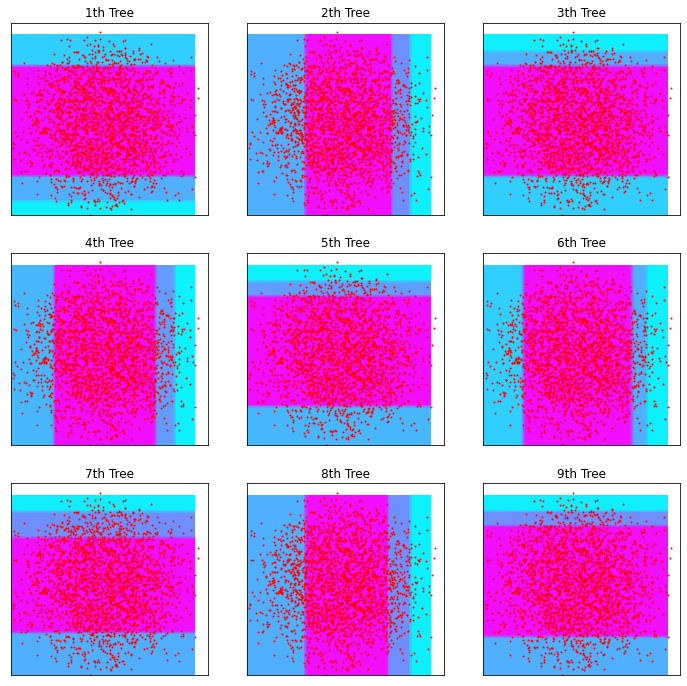

In [4]:
#Specify the plot grid

from pylab import rcParams
rcParams['figure.figsize'] = 12, 12

plot_step = 0.02
x_min, x_max = X['X1'].min(), X['X1'].max()
y_min, y_max = X['X2'].min(), X['X2'].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

#Now plot
fig = plt.figure()

for i in range(1,10):
    ax = fig.add_subplot(3, 3, i)
    Z = gbc.estimators_[i][0].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.cool)
    plt.plot(X['X1'][(Y==1)], X['X2'][(Y==1)], 'r.', markersize = 2)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('{}th Tree'.format(i))

<p>Now let's plot the decision surface of the classifier. I.e., we will look at:<br><br>
<center>$P^m(X) = [1+e^{-F^m(X)}]^{-1}$</center>
for different values of m.

</p>

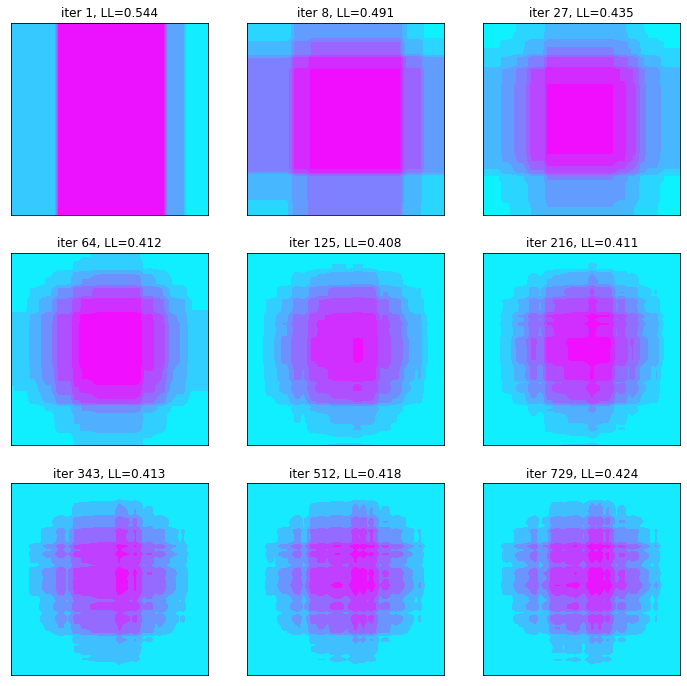

In [5]:
#Predict on the grid points, which were defined above
p_gen = gbc.staged_predict_proba(np.c_[xx.ravel(), yy.ravel()])
p_test = gbc.staged_predict_proba(X_test)

#Now plot
fig = plt.figure()

k = 3

ms = np.arange(1, k*k + 1)**3

cnt = 0
for i in range(1, k*k + 1):
    while (cnt < ms[i-1]):
        Z = next(p_gen)[:, 1]
        P = next(p_test)[:, 1]
        LL = LogLossP(P, Y_test)
        cnt += 1
        
    Z = Z.reshape(xx.shape)
    ax = fig.add_subplot(k, k, i)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.cool)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('iter {}, LL={}'.format(cnt, round(LL,3)))

<p>In the above plots we can get a good sense of the bias-variance tradeoff of the GBT classifier. With a few iterations, we get a large box in the middle with very little curvature around it. As we add more boosts, we can see how the decision surface gets more spherical. With this also increase we also see the prediction region becoming more speckled with predictions of the negative class (blue). This is the GBT fitting noisy points within the circle. We can see how the log-loss decreases as we add more trees, but eventually it goes up again. Overall though, on this data, it is better to err on more tree than fewer. This method is more robust to high variance than to high bias.

</p>

## A Simulation Bakeoff

<p>In this section we'll compare Gradient Boosting to two other non-linear methods: Random Forests and SVM with Radial Basis Kernel. We'll first generate 2 datasets that have highly non-linear decision boundaries. The following two data sets are generated from the same underlying geometry, only one has a lot of noise added to it.
</p>

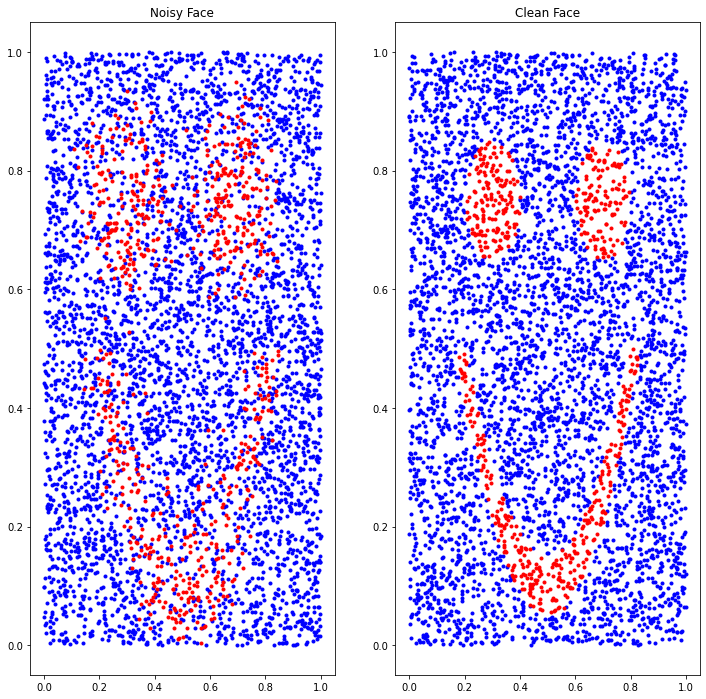

In [6]:
import os
# os.chdir("C:/Users/kevin/Documents/GitHub/DS_course/ipython/")
os.chdir("../")
from course_utils import *

noisy_train = happyClass(0.015, 2000)
clean_train = happyClass(0.0001, 2000)    
noisy_test = happyClass(0.015, 5000)
clean_test = happyClass(0.0001, 5000)    

fig = plt.figure()

plt.subplot(1, 2, 1)
plt.title('Noisy Face')
plt.plot(noisy_test.X1[(noisy_test.Y==0)], noisy_test.X2[(noisy_test.Y==0)], 'b.')
plt.plot(noisy_test.X1[(noisy_test.Y==1)], noisy_test.X2[(noisy_test.Y==1)], 'r.')

plt.subplot(1, 2, 2)
plt.title('Clean Face')
plt.plot(clean_test.X1[(clean_test.Y==0)], clean_test.X2[(clean_test.Y==0)], 'b.')
plt.plot(clean_test.X1[(clean_test.Y==1)], clean_test.X2[(clean_test.Y==1)], 'r.')

<p> Next we'll do the bakeoff. The goal here is to see how the above algorithms perform on the above simulated data. We also want to compare the decision surfaces so that we can pull a bit of geometric intuition about how each classifier operates. For each classifier type in this bakeoff we'll use SKLearn's GridsearchCV to perform cross-validation to choose a set of optimal hyper-parameters.


</p>

In [7]:
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble  import RandomForestClassifier
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.svm import SVC

boost_grid = {'n_estimators':[20, 50, 100, 500, 1000]}
rf_grid = {'n_estimators':[20, 50, 100, 500, 1000], 'max_features':[1, 2]}
svm_grid = {'C': [1000, 10000, 100000], 'gamma': [100, 10, 1, 0.1], 'kernel': ['rbf']}


#We define a KFold object so that all tests get the same folds
# kf = KFold(noisy_train.shape[0], n_folds=5)
kf = KFold(n_splits=5)

boost_cv = GridSearchCV(GradientBoostingClassifier(), boost_grid, cv = kf, scoring = 'roc_auc')
boost_cv.fit(noisy_train.drop('Y', 1), noisy_train.Y)

rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv = kf, scoring = 'roc_auc')
rf_cv.fit(noisy_train.drop('Y', 1), noisy_train.Y)

svm_cv = GridSearchCV(SVC(), svm_grid, cv = kf, scoring = 'roc_auc')
svm_cv.fit(noisy_train.drop('Y', 1), noisy_train.Y)
#We need these steps to get the prob estimate off of the SVM
svc = svm_cv.best_estimator_
svc.probability = True
svc.fit(noisy_train.drop('Y', 1), noisy_train.Y)

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

<p>Now let's plot these

</p>

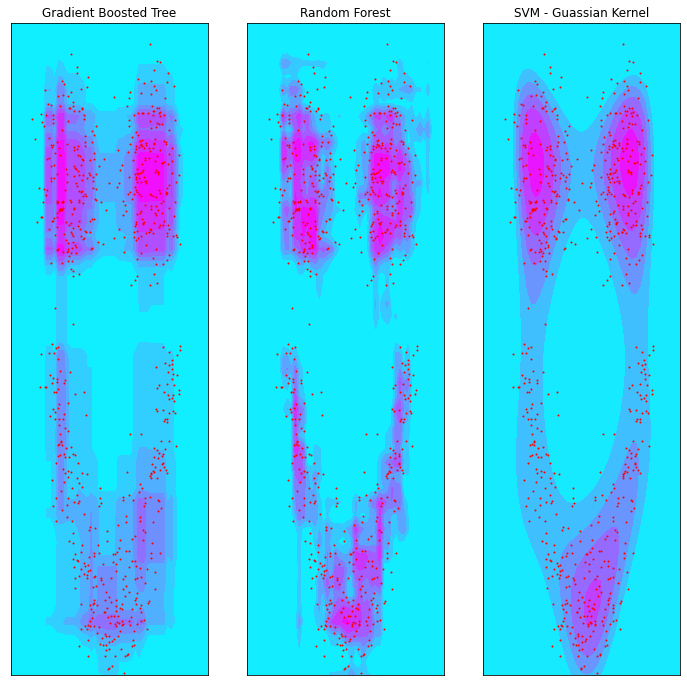

In [8]:
def plotZgen(clf, dat, pc, t, fig):
    '''
    This plots a 2d decision boundary given a trained classifier
    Note the data must have two fields X1 and X2 to work
    '''
    plot_step = 0.02
    x_min, x_max = dat['X1'].min(), dat['X1'].max()
    y_min, y_max = dat['X2'].min(), dat['X2'].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax = fig.add_subplot(pc[0], pc[1], pc[2])
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.cool)
    plt.plot(dat['X1'][(dat.Y==1)], dat['X2'][(noisy_test.Y==1)], 'r.', markersize = 2)
    plt.title(t)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


fig = plt.figure()
plotZgen(boost_cv, noisy_test, (1, 3, 1), 'Gradient Boosted Tree', fig)
plotZgen(rf_cv, noisy_test, (1, 3, 2), 'Random Forest', fig)
plotZgen(svc, noisy_test, (1, 3, 3), 'SVM - Guassian Kernel', fig)

# References
<p>The following list of references are recommended for a complete review of both the implementation and theory of Gradient Boosted Trees.<br>
<ul>
    <li><a href="http://en.wikipedia.org/wiki/Gradient_boosting">Sklearn's GBT Documentation</a></li>
    <li><a href="http://scikit-learn.org/stable/modules/ensemble.html">Wikipedia</a></li>


</ul>


</p>